A topographic map of Pakistan using Rasterio, geopandas, EarthPy, etc.

In [1]:
import os
import osgeo
import rasterio
from rasterio.merge import merge

In [2]:
# Make a list containing the paths to each tif DEM image in the folder structure
file_list = []

for (root, dirs, files) in os.walk(".", topdown=True):
    for file in files:
        if file.endswith('.tif'):
            file_path = os.path.join(root, file)
            file_list.append(file_path)


In [3]:
# Add all rasters to a mosaic using rasterio
srcs_to_mosaic = [rasterio.open(f) for f in file_list]

# merge has 2 returns - arr stores the combined data, and out_trasnform has the data necessary for further trannsforamtions
arr, out_transform = merge(srcs_to_mosaic)  


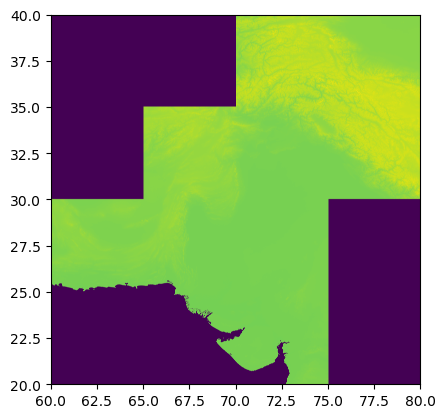

<Axes: >

In [ ]:
import matplotlib.pyplot as plt
from rasterio.plot import show

# show(arr, transform=out_transform)

In [10]:
# Storing the intermediate mosaic data in memory to perform intermediate steps greatly improves code performance

from rasterio.io import MemoryFile
import numpy as np

memfile = MemoryFile()
dataset = memfile.open(driver='GTiff', 
                       height=arr[0].shape[0], 
                       width=arr[0].shape[1], 
                       count=1, 
                       crs=srcs_to_mosaic[0].crs, 
                       transform=out_transform, 
                       dtype=np.float64)
dataset.write(arr[0], 1)

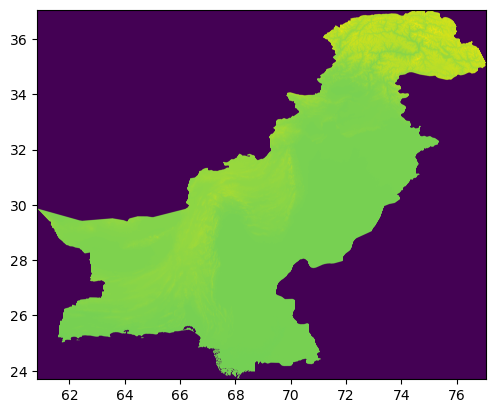

In [11]:
import geopandas as gpd

from shapely.geometry import mapping
from rasterio.mask import mask

df = gpd.read_file("../map2_lines/natural_earth/ne_10m_admin_0_countries.shp")
pakistan = df.loc[df['ADMIN'] == "Pakistan"]

clipped_array, clipped_transform = mask(dataset,
                                       [mapping(geom) for geom in (pakistan.geometry.tolist())],
                                       crop=True,
                                       nodata=20000)
clipped_array[clipped_array == 20000] = np.amin(clipped_array) - 1

fig, ax = plt.subplots()
show(clipped_array, ax=ax, transform=clipped_transform)
plt.show()

In [17]:
np.amin(np.float64(clipped_array))

np.float64(-32769.0)

In [18]:
np.amax(np.float64(clipped_array))

np.float64(8569.0)

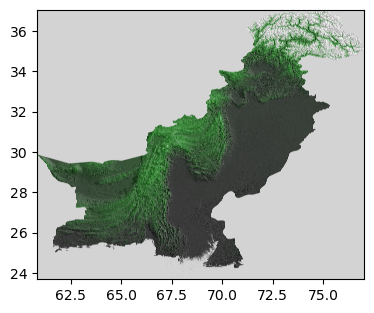

In [25]:
from matplotlib.colors import ListedColormap
from matplotlib.colors import BoundaryNorm
from matplotlib.colors import LinearSegmentedColormap
import earthpy.spatial as es

cmap = LinearSegmentedColormap.from_list('pakistan', ['black', 'green', '#ffffff'])
newcolors = cmap(np.linspace(0, 1, int((abs(np.amin(clipped_array) +
abs(np.amax(clipped_array)))) / 10)))
newcolors[:1, :] = np.array([1.0, 1.0, 1.0, 1.0])
cmap = ListedColormap(newcolors)

bounds = np.arange(0, np.amax(np.float64(clipped_array))-4000, 10)
norm = BoundaryNorm(bounds, cmap.N)

from matplotlib import colors

fig, ax = plt.subplots()
fig.set_size_inches(7, 3.5)

hillshade = es.hillshade(clipped_array[0], azimuth=240, altitude=1)

show(clipped_array, ax=ax, transform=clipped_transform, cmap=cmap, norm=norm)
show(hillshade, transform=clipped_transform, cmap="Greys", alpha=0.4)
ax.axis('off')
plt.show()

add hillshade with earthPy